<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Lesson 16 - Time Series Modelling

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Independent Practice: Walmart Sales Data

For the independent practice, we will analyse the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analysing one store for simplicity.

The data includes:

- **Store** - the store number
- **Dept** - the department number
- **Date** - the week
- **Weekly_Sales** -  sales for the given department in the given store
- **IsHoliday** - whether the week is a special holiday week


Retrieved from [Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data)

> You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

> In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

#### Loading the data and setting the DateTimeIndex

In [2]:
data = pd.read_csv('../dataset/Walmart.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [3]:
# Filter to store 1 sales and sum over weeks
store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W').sum()
store1_sales.head()

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

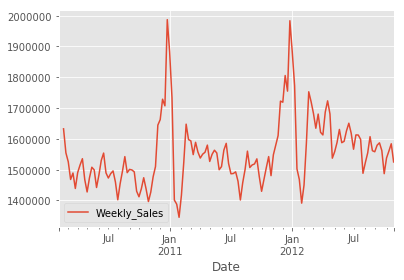

In [4]:
store1_sales[['Weekly_Sales']].rolling(window=3).mean().plot()
plt.show()

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [5]:
print('Autocorrelation 1: ', store1_sales['Weekly_Sales'].autocorr(1))
print('Autocorrelation 2: ', store1_sales['Weekly_Sales'].autocorr(2))
print('Autocorrelation 52: ', store1_sales['Weekly_Sales'].autocorr(52))

('Autocorrelation 1: ', 0.30215827941131262)
('Autocorrelation 2: ', 0.12741313055390102)
('Autocorrelation 52: ', 0.89537602947770101)


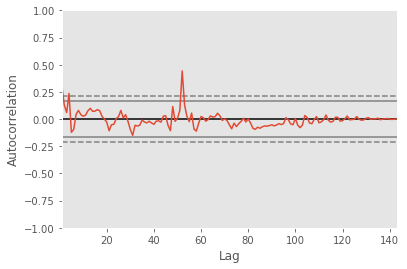

In [6]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_sales['Weekly_Sales'])
plt.show()

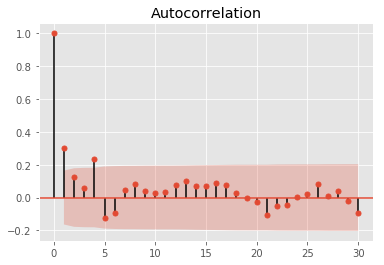

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_sales['Weekly_Sales'], lags=30)
plt.show()

 #### What does the autocorrelation plot say about the type of model you want to build?

Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4.
In the plot above notice the spike at around 52 - implying a yearly pattern as well.
No random spikes, probably not much use for a moving average model.

#### Split the weekly sales data in a training and test set - using 75% of the data for training

In [8]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.75*n)]
test = store1_sales.Weekly_Sales[int(.75*n):]

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [9]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [19]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-31',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81839.338631623992)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Mon, 10 Jul 2017   AIC                           2875.327
Time:                        20:41:08   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001       0.133       0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

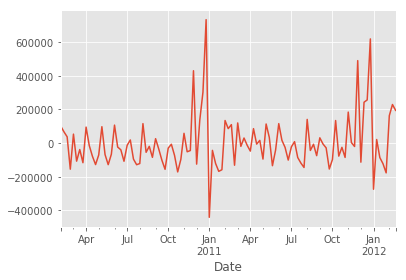

In [20]:
model.resid.plot()
plt.show()

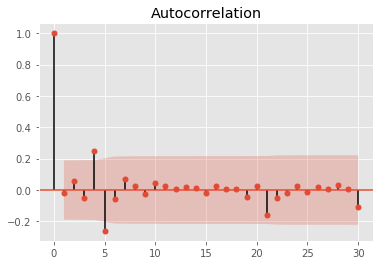

In [21]:
plot_acf(model.resid, lags=30)
plt.show()

#### Compute an AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?

In [13]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81203.239354419813)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Mon, 10 Jul 2017   AIC                           2876.963
Time:                        17:14:34   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000     1.5e+06    1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003       0.108       0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548      -0.132       0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3588           +0.0000j            7.3588            0.5000
-----------------------------------------------------------------------------
"""

In [14]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 80503.159198756999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144109.084
Date:                Mon, 10 Jul 2017   AIC                           2863.563
Time:                        17:14:34   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.320      0.000    1.51e+06    1.58e+06
ar.L1.Weekly_Sales    -1.0398      0.090    -11.583      0.000      -1.216      -0.864
ar.L2.Weekly_Sales    -0.4701      0.087     -5.380      0.000      -0.641      -0.299
ma.L1.Weekly_Sales     1.4692      0.058     25.365      0.000       1.356       1.583
ma.L2.Weekly_Sales     0.9998      0.074     13.532      0.000       0.855       1.145
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.9509j            1.4585           -0.3870
AR.2           -1.1059           +0.9509j            1.4585            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [15]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit(trend='nc',method='css-mle',maxiter=100000)

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 76300.613127243458)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1414.335
Method:                       css-mle   S.D. of innovations         145520.327
Date:                Mon, 10 Jul 2017   AIC                           2840.670
Time:                        17:14:34   BIC                           2856.650
Sample:                    02-14-2010   HQIC                          2847.147
                         - 02-19-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
ar.L1.D.Weekly_Sales    -1.0564      0.092    -11.470      0.000      -1.237      -0.876
ar.L2.D.Weekly_Sales    -0.4864      0.089     -5.443      0.000      -0.662      -0.311
ma.L1.D.Weekly_Sales     0.5190      0.073      7.113      0.000       0.376       0.662
ma.L2.D.Weekly_Sales    -0.3968      0.076     -5.197      0.000      -0.547      -0.247
ma.L3.D.Weekly_Sales    -0.9500      0.081    -11.780      0.000      -1.108      -0.792
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0859           -0.9363j            1.4338           -0.3868
AR.2           -1.0859           +0.9363j            1.4338            0.3868
MA.1            1.0522           -0.0000j            1.0522           -0.0000
MA.2           -0.7350           -0.6784j            1.0002           -0.3814
MA.3           -0.7350           +0.6784j            1.0002            0.3814
-----------------------------------------------------------------------------
"""